In [36]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import pandas as pd

# Enable interactive figures for latest versions of Jupyter Lab, with 'jupyter-matplotlib' 'widgetsnbextension' installed and activated.
#%matplotlib widget
# If no figure is showing, replace with
%matplotlib inline

## DMD


In [37]:
# If there is some "File not found error" try to reboot the Kernel or to use Jupyter Lab to run this Noteobok
hare_lynx_data = pd.read_csv('./data/hare_lynx_data.csv', index_col=0)
data = hare_lynx_data.to_numpy().transpose()
dT = 2 #2 years
X = data[:, 0:-1]
Xprime = data[:, 1:]

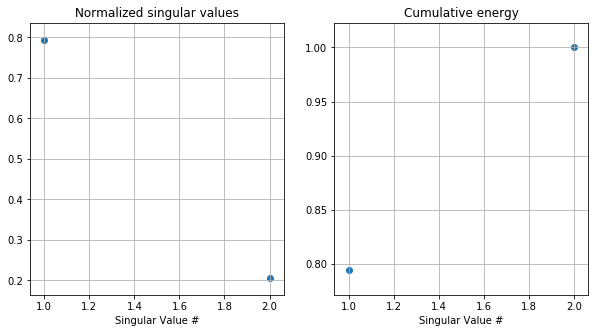

In [38]:
# Economy SVD
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.T
S_norm = S / sum(S)

# Plot normalized singular values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.grid()
ax1.set_title('Normalized singular values')
ax1.set_xlabel('Singular Value #')
ax1.scatter(range(1, len(S_norm)+1), S_norm)

ax2.grid()
ax2.set_title('Cumulative energy')
ax2.set_xlabel('Singular Value #')
ax2.scatter(range(1, len(S_norm)+1), np.cumsum(S_norm))

In [39]:
# Then we apply DMD formulas to construct the DMD model of the system
Sigma = np.diag(S)
A_tilde = U.conj().T @ Xprime @ V @ np.linalg.inv(Sigma)

print(A_tilde)

[[ 0.78432864 -0.27448476]
 [ 0.08809328  0.31886118]]


In [40]:
Lambda, W = np.linalg.eig(A_tilde)
# Modes
Phi = Xprime @ V @ np.linalg.inv(Sigma) @ W
# Eigenvalues
omega = np.log(Lambda) / dT     #dT = 2 years

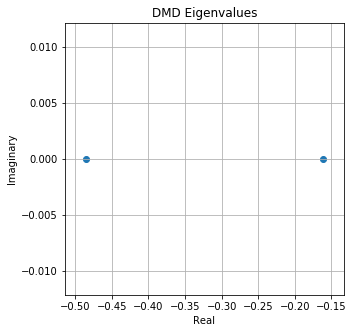

In [73]:
plt.figure(3, figsize=(5, 5))
plt.scatter(np.real(omega), np.imag(omega))
plt.title('DMD Eigenvalues')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.savefig('figs/DMD_eigenvalues.png')

In [44]:
# Eventually we need to find the loading vector
B = np.linalg.inv(Phi) @ X[:, 0]
print(B)

[28.67853772 52.50084268]


In [45]:
t_meas = range(0, dT * len(X[0]), dT)
t = range(0, dT * len(X[0]), dT)

# DMD model is compared to the measurements
X_pred = np.array([Phi[:, 0] * np.exp(omega[0] * tau) * B[0] + Phi[:, 1] * np.exp(omega[1] * tau) * B[1] for tau in t]).T
X_meas = np.array(X)


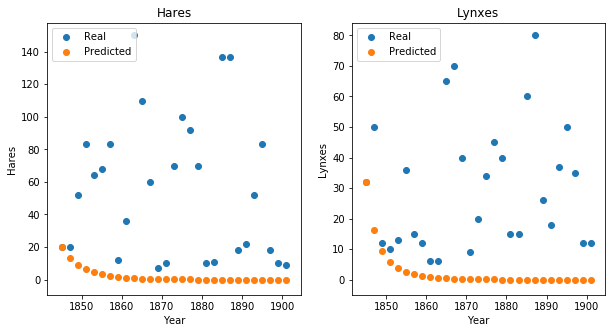

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), X_pred[0, :])
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), X_pred[1, :])
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Lynxes')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')
plt.savefig('figs/DMD_performances.png')

## DMD with pyDMD

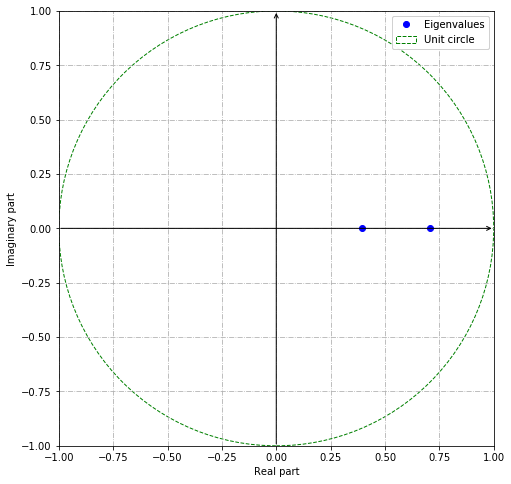

Text(0.5, 1.0, 'Lynxes')

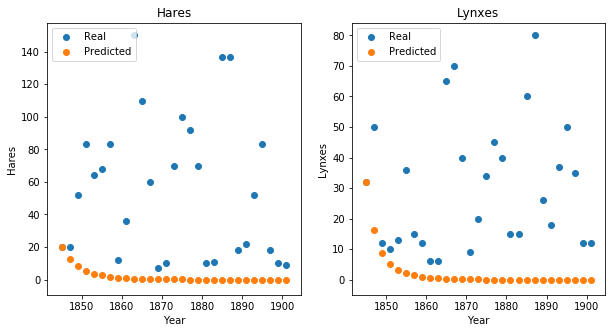

In [49]:
# DMD is also tested with pyDMD
from pydmd import DMD
dmd = DMD(svd_rank=2)
dmd.fit(X)
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), dmd.reconstructed_data[0, :])
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), dmd.reconstructed_data[1, :])
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Lynxes')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')

## DMD with time-delay embedding

In [50]:
# Time delays to embedd
p = 9
k = 29 - p

# Hankel Matrix
H = np.array([X[:, i:k+i] for i in range(0, p)]).reshape((-1, k))
Hprime = np.array([Xprime[:, i:k+i] for i in range(0, p)]).reshape((-1, k))

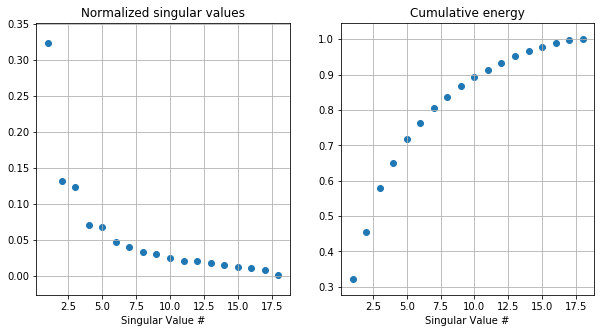

In [80]:
# Do SVD and plot the singular values
U_td,S_td, Vh_td = np.linalg.svd(H, full_matrices=False)
V_td = Vh_td.T
S_td_norm = S_td / sum(S_td)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.grid()
ax1.set_title('Normalized singular values')
ax1.set_xlabel('Singular Value #')
ax1.scatter(range(1, len(S_td_norm)+1), S_td_norm)

ax2.grid()
ax2.set_title('Cumulative energy')
ax2.set_xlabel('Singular Value #')
ax2.scatter(range(1, len(S_td_norm)+1), np.cumsum(S_td_norm))
plt.savefig('figs/DMD_delay_singular_values.png')

In [52]:
# r=12 truncation, and application of DMD formulas
r = 12
Ur = U_td[:, 0:r]
Sigma_r = np.diag(S_td[0:r])
Vr = V_td[:, 0:r]
Ar_tilde = Ur.conj().T @ Hprime @ Vr @ np.linalg.inv(Sigma_r)

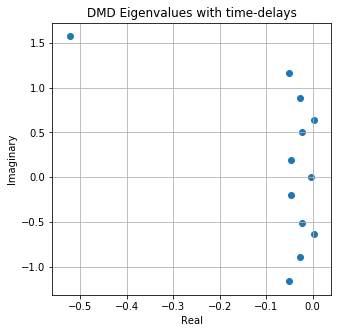

In [81]:
Lambdar, Wr = np.linalg.eig(Ar_tilde)
Phir = Hprime @ Vr @ np.linalg.inv(Sigma_r) @ Wr
omegar = np.log(Lambdar) / dT     #dT = 2 years

plt.figure(figsize=(5, 5))
plt.scatter(np.real(omegar), np.imag(omegar))
plt.title('DMD Eigenvalues with time-delays')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.savefig('figs/DMD_delay_eigenvalues.png')

In [56]:
Br = np.linalg.pinv(Phir) @ H[:, 0]
print(Br)

Xr_pred = np.zeros((2*p, len(t_meas)))
for i in range(0, r):
    Xr_pred = Xr_pred + np.array([Phir[:, i] * np.exp(omegar[i] * tau) * Br[i] for tau in t_meas]).T

[-196.46039253+1.17672500e-15j  -16.19336266-2.61395522e+01j
  -16.19336266+2.61395522e+01j   -0.28208317+3.29336554e+01j
   -0.28208317-3.29336554e+01j  -35.1447162 +1.67912155e+01j
  -35.1447162 -1.67912155e+01j   34.02836213-2.78955621e+01j
   34.02836213+2.78955621e+01j    6.82553525+1.46494714e+01j
    6.82553525-1.46494714e+01j   -5.25870099-1.05575645e-14j]


C:\Users\fabio\anaconda3\envs\ML\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


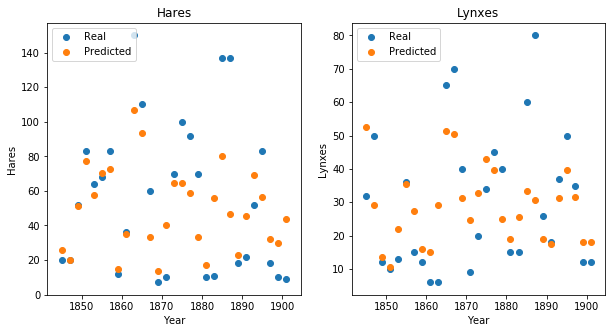

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), Xr_pred[0, :])
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), Xr_pred[1, :])
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Lynxes')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')
plt.savefig('figs/DMD_delay_performances.png')

## Fitting Lotka-Volterra
From "Lotka–Volterra model parameter estimation using experiential data"

In [58]:
# Data-set matrices in the new coordinates
Y = np.array([[X[0, i], X[1, i], X[0, i]*X[1, i]] for i in range(0, X.shape[1])]).T
Yprime = np.array([[Xprime[0, i], Xprime[1, i], Xprime[0, i]*Xprime[1, i]] for i in range(0, X.shape[1])]).T

X_lv = np.zeros((0, 2, 2))
d_lv = np.zeros((0, 1, 2))

# build the auxiliary X_bar and d_bar matrices as described by the paper
for t in range(0, X.shape[1]-1):
    X_append = np.zeros((2, 2))
    d_append = np.zeros((1, 2))

    X_append[:, 0] = np.array([ (X[0, t+1] + X[0, t])/2, (X[0, t+1]*X[1, t+1] + X[0, t]*X[1, t])/2 ])
    X_append[:, 1] = np.array([ (X[0, t+1]*X[1, t+1] + X[0, t]*X[1, t])/2, (X[1, t+1] + X[1, t])/2 ])
    d_append[0, 0] = np.array([  X[0, t+1] - X[0, t] ])
    d_append[0, 1] = np.array([  X[1, t+1] - X[1, t] ])

    X_lv = np.append(X_lv, X_append.reshape((1, 2, 2)), axis=0)
    d_lv = np.append(d_lv, d_append.reshape((1, 1, 2)), axis=0)

# then, find the Lotka-Volterra parameters by solving a simple linear system, 
a_x = np.linalg.pinv(X_lv[:, :, 0]) @ d_lv[:, :, 0]
a_y = np.linalg.pinv(X_lv[:, :, 1]) @ d_lv[:, :, 1]

b_lv = a_x[0, 0]
p_lv = -a_x[1, 0]
r_lv = a_y[0, 0]
d_lv = a_y[1, 0]


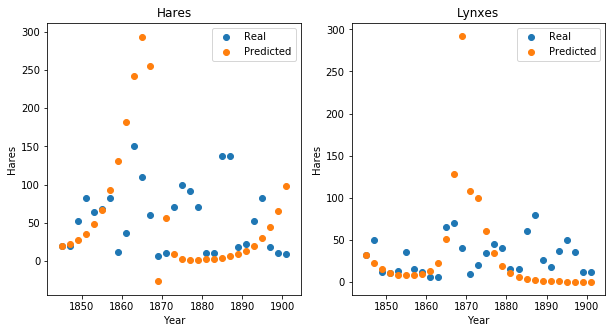

In [77]:
x_lv = np.zeros((Y.shape[1],))
y_lv = np.zeros((Y.shape[1],))

# Initialization of the Lotka-Volterra model and simulation
x_lv[0] = X[0, 0]
y_lv[0] = X[1, 0]

for i in range(1, x_lv.shape[0]):
    x_lv[i] = x_lv[i-1] + (b_lv - p_lv * y_lv[i-1]) * x_lv[i-1]
    y_lv[i] = y_lv[i] + (r_lv * x_lv[i-1] - d_lv) * y_lv[i-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), x_lv)
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), y_lv)
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Hares')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')

plt.savefig('figs/Lotka_paper.png')


## Koopman-DMD assuming Lotka-Volterra model
Recalling that the Lotka-Volterra model is $\dot{x}_1 = (b-px_2)x_1 $ and $\dot{x_2} = (rx_1-d)x_2$, we here assume that such model is the exact model of the system, so that a suitable change of coordinates is $y = g(x) = [ x_1, \, x_2, \, x_1 \cdot x_2 ]^T$.

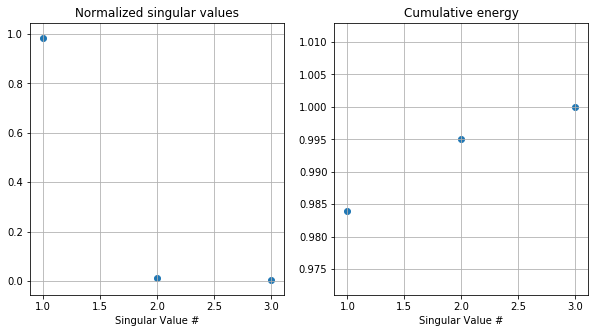

In [60]:
# Application of the SVD to the Y data-set matrix
Uy, Sy, Vyh = np.linalg.svd(Y, full_matrices=False)
Vy = Vyh.T
Sy_norm = Sy / sum(Sy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.grid()
ax1.set_title('Normalized singular values')
ax1.set_xlabel('Singular Value #')
ax1.scatter(range(1, len(Sy_norm)+1), Sy_norm)

ax2.grid()
ax2.set_title('Cumulative energy')
ax2.set_xlabel('Singular Value #')
ax2.scatter(range(1, len(Sy_norm)+1), np.cumsum(Sy_norm))

In [61]:
# Application of DMD in the new coordinates
Sigma_y = np.diag(Sy)
Ay_tilde = Uy.conj().T @ Yprime @ Vy @ np.linalg.inv(Sigma_y)

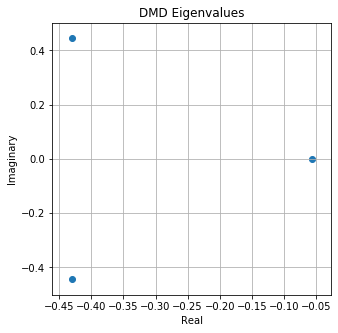

In [62]:
Lambday, Wy = np.linalg.eig(Ay_tilde)
Phiy = Yprime @ Vy @ np.linalg.inv(Sigma_y) @ Wy
omegay = np.log(Lambday) / dT     #dT = 2 years
plt.figure(figsize=(5, 5))
plt.scatter(np.real(omegay), np.imag(omegay))
plt.title('DMD Eigenvalues')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()

In [63]:
By = np.linalg.pinv(Phiy) @ Y[:, 0]
print(By)

Xy_pred = np.zeros((3, len(t_meas)))
for i in range(0, 3):
    Xy_pred = Xy_pred + np.array([Phiy[:, i] * np.exp(omegay[i] * tau) * By[i] for tau in t_meas]).T
# In our case there is no need of applying an inverse coordinate transformation, since x_1 = y_1 and x_2 = y_2 

[-2167.41784789-3.02160115e-15j -1039.10293284-2.81228333e+03j
 -1039.10293284+2.81228333e+03j]


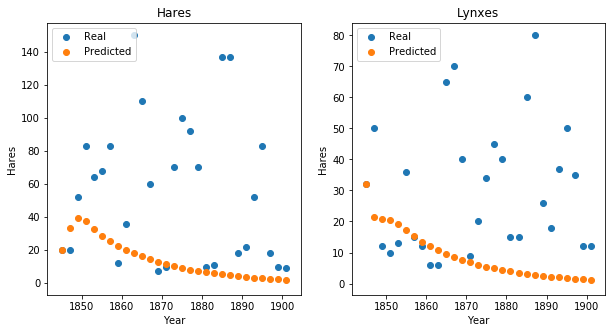

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), Xy_pred[0, :])
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), Xy_pred[1, :])
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Hares')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')

plt.savefig('figs/Lotka_Koopman.png')

## Koopman with time-delay embedding

In [65]:
# Time delay to embed
q = 9
p = 29 - q

# Hankel Matrix
Hy = np.array([Y[:, i:p+i] for i in range(0, q)]).reshape((-1, p))
Hyprime = np.array([Yprime[:, i:p+i] for i in range(0, q)]).reshape((-1, p))

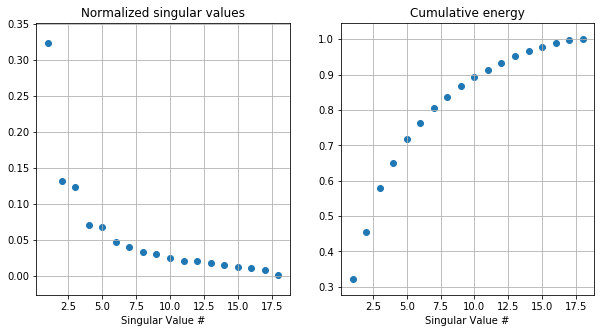

In [66]:
# Do SVD and plot the singular values
Uy_td,Sy_td, Vyh_td = np.linalg.svd(Hy, full_matrices=False)
Vy_td = Vyh_td.T
Sy_td_norm = Sy_td / sum(Sy_td)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.grid()
ax1.set_title('Normalized singular values')
ax1.set_xlabel('Singular Value #')
ax1.scatter(range(1, len(S_td_norm)+1), S_td_norm)

ax2.grid()
ax2.set_title('Cumulative energy')
ax2.set_xlabel('Singular Value #')
ax2.scatter(range(1, len(S_td_norm)+1), np.cumsum(S_td_norm))

In [67]:
# Rank truncation at r=14
ry = 14
Uyr = Uy_td[:, 0:ry]
Sigma_yr = np.diag(Sy_td[0:ry])
Vyr = Vy_td[:, 0:ry]
Ayr_tilde = Uyr.conj().T @ Hyprime @ Vyr @ np.linalg.inv(Sigma_yr)

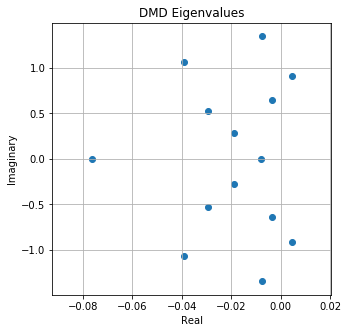

In [68]:
Lambdayr, Wyr = np.linalg.eig(Ayr_tilde)
Phiyr = Hyprime @ Vyr @ np.linalg.inv(Sigma_yr) @ Wyr
omegayr = np.log(Lambdayr) / dT     #dT = 2 years
plt.figure(figsize=(5, 5))
plt.scatter(np.real(omegayr), np.imag(omegayr))
plt.title('DMD Eigenvalues')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()

In [69]:
Byr = np.linalg.pinv(Phiyr) @ Hy[:, 0]
print(Byr)

Xyr_pred = np.zeros((3*q, len(t_meas)))
for i in range(0, r):
    Xyr_pred = Xyr_pred + np.array([Phiyr[:, i] * np.exp(omegayr[i] * tau) * Byr[i] for tau in t_meas]).T

[  473.15271498-4.82991606e+02j   473.15271498+4.82991606e+02j
  -779.69995629-2.37404169e+02j  -779.69995629+2.37404169e+02j
   846.45762934-6.60979089e+02j   846.45762934+6.60979089e+02j
  9405.11919527+2.88338936e-11j -6899.85727607-4.06736866e-11j
  -865.4223672 -9.14173010e+02j  -865.4223672 +9.14173010e+02j
  1018.58615222-1.31823480e+03j  1018.58615222+1.31823480e+03j
  -565.3177494 -1.27649731e+03j  -565.3177494 +1.27649731e+03j]


Text(0.5, 1.0, 'Lynxes')

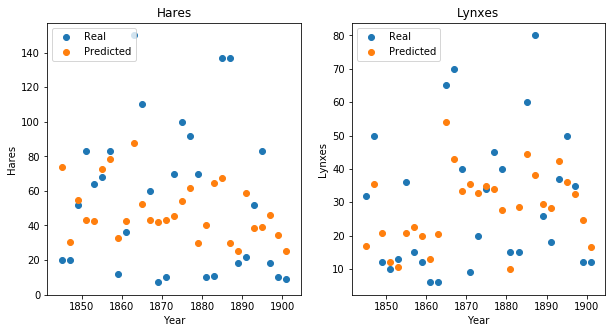

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), Xyr_pred[0, :])
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), Xyr_pred[1, :])
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Lynxes')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')

## SINDy

In [71]:
import pysindy as ps
from sklearn.linear_model import Lasso

x0[k+1] = 1.688 x0[k] + -0.007 x0[k]^2 + -0.010 x1[k]^2
x1[k+1] = 0.530 x0[k] + -0.001 x0[k]^2 + 0.002 x1[k]^2


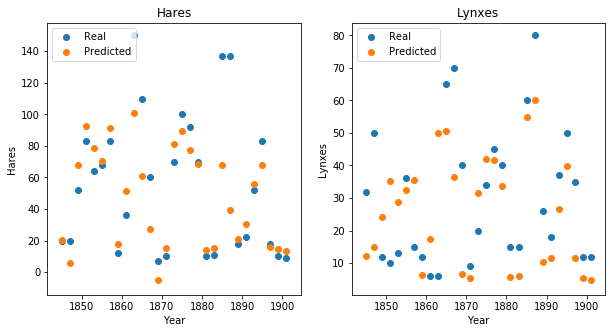

In [79]:
# We adopt as SINDy library the set of polynomials just for simplicity, and we specify that our system is discrete-time.
sindymodel = ps.SINDy(feature_library=ps.PolynomialLibrary(include_interaction=False), discrete_time=True, optimizer=Lasso(alpha=200, fit_intercept=False))
# In case of discrete-time systems, x_dot = x(k+1)
sindymodel.fit(X.T, t=dT, x_dot=Xprime.T)
sindymodel.print()

X_sindy = sindymodel.predict(X_meas.T)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(np.add(t_meas, 1845), X_meas[0, :])
ax1.scatter(np.add(t_meas, 1845), X_sindy[:, 0])
ax1.legend(['Real', 'Predicted'])
ax1.set_ylabel('Hares')
ax1.set_xlabel('Year')
ax1.set_title('Hares')

ax2.scatter(np.add(t_meas, 1845), X_meas[1, :])
ax2.scatter(np.add(t_meas, 1845), X_sindy[:, 1])
ax2.legend(['Real', 'Predicted'])
ax2.set_ylabel('Lynxes')
ax2.set_xlabel('Year')
ax2.set_title('Lynxes')

plt.savefig('figs/SINDy_performance.png')
score = sindymodel.score(X.T, t=dT, x_dot=Xprime.T)